In [1]:
## Importamos paquetes
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import solve_ivp

%matplotlib inline


## Parámetros para graficar
sns.set_style('darkgrid')
sns.set_context('talk')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

BLUE = '#1f77b4'
ORANGE = '#ff7f0e'
GREEN = '#2ca02c'
PURPLE = '#9467bd'

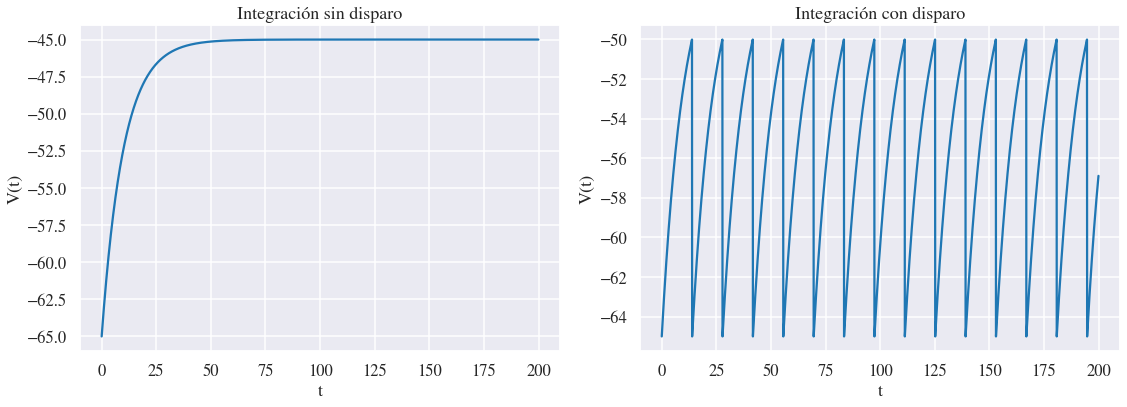

In [28]:
E_L = -65  ## Potencial de reposo
Rm  = 10   ## Resistencia de membrana
Ie  = 2    ## Corriente externa
Vth = -50  ## Voltaje de threshold
tau = 10   ## Tiempo característico

def integrate(t, y, *args):
    """
    Modelo neuronal de un compartimento
    con corriente externa constante
    """
    tau, E_L, Rm, Ie = args
    
    dydt = (1/tau)* (E_L - y + Rm*Ie)
    
    return dydt


def integrateAndFire(integrate_func, t0, tf, h, y0, *args):
    
    def fire(t, y, *args):
        return y[0] - Vth
    fire.terminal = True
    
    sols = []
    t_spikes = []
    t = t0
    while t < tf:
        t_span = (t0, tf)
        t_eval = np.arange(t0, tf, h)
        sol = solve_ivp(
            integrate_func, t_span=t_span, t_eval=t_eval, 
            y0=y0, max_step=h, args=args, 
            events=fire
        )
        sols.append(sol)
        t_events = sol.t_events[0]

        if t_events.size == 0:
            break

        t_spike = t_events[0]
        t_spikes.append(t_spike)
        t0 = t_spike + h

    t_values = np.concatenate([sol.t for sol in sols])
    y_values = np.concatenate([sol.y[0] for sol in sols])    
    return t_values, y_values, t_spikes


## Parámetros de integración
t0 = 0                        ## Tiempo inicial
tf = 200                      ## Tiempo final
h  = 0.05                     ## Paso de integración
t_span = (t0, tf)
t_eval = np.arange(t0, tf, h)

y0 = (E_L,)                   ## Condicion inicial
args = (tau, E_L, Rm, Ie)

sol_no_fire = solve_ivp(
    integrate, t_span=t_span, t_eval=t_eval, 
    y0=y0, max_step=h, args=args, 
)

t_values, y_values, t_spikes = integrateAndFire(
    integrate,
    t0, tf, h, y0, *args
)

## Graficamos las soluciones
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_title('Integración sin disparo')
ax.set_ylabel('V(t) [mV]')
ax.set_xlabel('t [ms]')
ax.plot(sol_no_fire.t, sol_no_fire.y[0])

ax = axes[1]
ax.set_title('Integración con disparo')
ax.set_ylabel('V(t) [mV]')
ax.set_xlabel('t [ms]')
ax.plot(t_values, y_values)

plt.tight_layout()
plt.show()

In [21]:
Ie_values = np.arange(2, 10, 0.5, dtype='float')
firing_rates = np.zeros_like(Ie_values)
for j, Ie in enumerate(Ie_values):
    print(Ie)
    
    y0 = (E_L,)
    args = (tau, E_L, Rm, Ie)

    t_values, y_values, t_spikes = integrateAndFire(
        t0, tf, h, y0, *args
    )

    if len(t_spikes) > 0:
        isi = np.diff(t_spikes).mean()
        firing_rate = 1/isi
        firing_rates[j] = firing_rate
    else:
        firing_rates[j] = np.inf

2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5


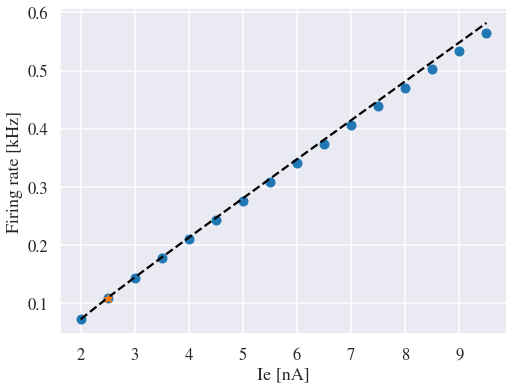

In [39]:
def theo_firing_rate(Ie, tau, Rm, E_L, Vreset, Vth):
    
    t_isi = tau*np.log((Rm*Ie+E_L-Vreset)/(Rm*Ie+E_L-Vth))
    r_isi = 1 / t_isi
    
    return r_isi

Vreset = E_L
theo_r_isi = theo_firing_rate(Ie_values, tau, Rm, E_L, Vreset, Vth)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax.set_ylabel('Firing rate [kHz]')
ax.set_xlabel('Ie [nA]')
ax.plot(Ie_values, firing_rates, 'o')
ax.plot(Ie_values, theo_r_isi, color='k', linestyle='--')
plt.show()

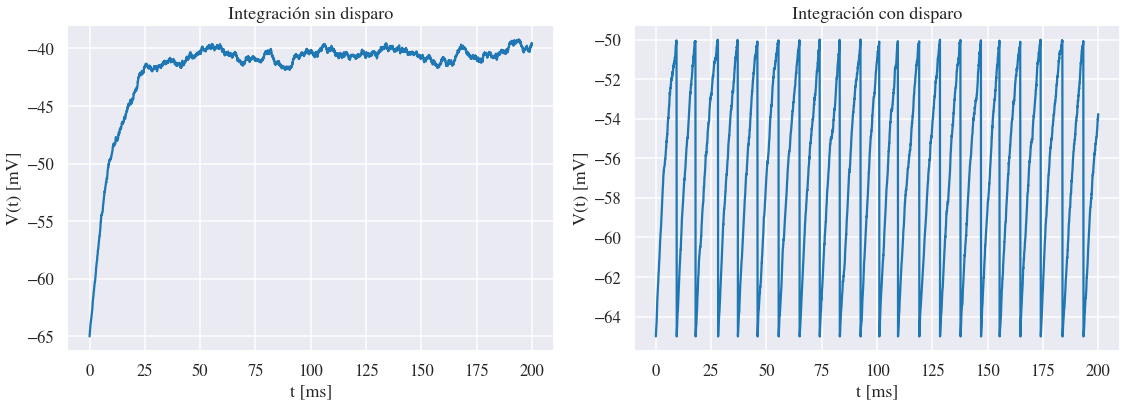

In [53]:
min_Ie = 0
max_Ie = 5
avg_Ie = (max_Ie - min_Ie) / 2

def integrate_rand_Ie(t, y, *args):
    """
    Modelo neuronal de un compartimento
    con corriente externa aleatoria
    """
    tau, E_L, Rm = args
    
    Ie = (max_Ie - min_Ie)*np.random.random()
    
    dydt = (1/tau)* (E_L - y + Rm*Ie)
    
    return dydt

y0 = (E_L,)                   ## Condicion inicial
args = (tau, E_L, Rm)

sol_no_fire = solve_ivp(
    integrate_rand_Ie, t_span=t_span, t_eval=t_eval, 
    y0=y0, max_step=h, args=args, 
)

t_values, y_values, t_spikes = integrateAndFire(
    integrate_rand_Ie,
    t0, tf, h, y0, *args
)

## Graficamos las soluciones
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_title('Integración sin disparo')
ax.set_ylabel('V(t) [mV]')
ax.set_xlabel('t [ms]')
ax.plot(sol_no_fire.t, sol_no_fire.y[0])

ax = axes[1]
ax.set_title('Integración con disparo')
ax.set_ylabel('V(t) [mV]')
ax.set_xlabel('t [ms]')
ax.plot(t_values, y_values)

plt.tight_layout()
plt.show()

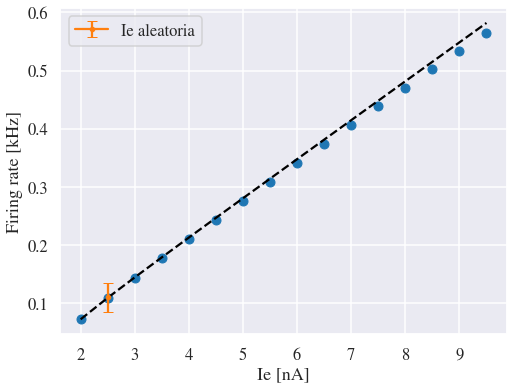

In [54]:
def calcular_periodo(x, h=1):
    """
    Calcula el período de una señal oscilante como el promedio
    entre dos tiempos consecutivos en los cuales la señal pasa 
    de tener un valor por debajo de la media a un valor por 
    encima de la media.
    """
    x = np.array(x)
    x = x - x.mean()
    
    ## Cantiddad de pasos entre valores positivos
    pasos_entre_pos = np.diff(np.where(x>0)[0])
    
    distancias = np.diff(np.where(pasos_entre_pos>1)[0][::2]) * h
    per = distancias.mean()
    per_std = distancias.std()
    
    return per, per_std

per, per_std = calcular_periodo(y_values, h=h)
r_isi = 1/per
r_isi_std = r_isi*per_std/per

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax.set_ylabel('Firing rate [kHz]')
ax.set_xlabel('Ie [nA]')
ax.plot(Ie_values, firing_rates, 'o')
ax.plot(Ie_values, theo_r_isi, color='k', linestyle='--')
ax.errorbar(
    avg_Ie, r_isi, r_isi_std, marker='.', capsize=5, label='Ie aleatoria', zorder=10
)
ax.legend()

plt.show()